<img src="https://thediplomat.com/wp-content/uploads/2022/10/sizes/td-story-s-2/thediplomat_2022-10-19-193918.jpg" style="width:50%; display: block; margin-left: auto; margin-right: auto">
<table style="width:50%">
    <tr>
        <th>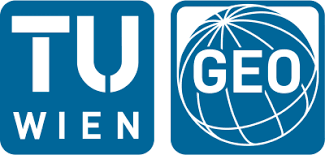</th>
        <th><img src="https://eodc.eu/wp-content/uploads/2018/10/EODC-Logo-Final.png"></th>
    </tr>
</table>

# DestinE Data Lake

The Destination Earth Data Lake (DEDL) combines such disparate data sources in one large virtual database. Moreover, this virtual database comes with a set of tools that facilitates the search for relevant resources as well as the analysis of data by performing computationally expensive operations near to the data source.

This Jupyter Notebook serves as an example of how the DEDL service could have helped with a disaster response assessment during the 2022 Pakistan flood.

# Pakistan Flood 2022

A disaster management expert is called to assess what the flood risk of the Indus River plain is if heavy rainfall continuous in the next days.

To address this issue the expert has to access data from several resources, which includes sociographic information about human settlements as well as physical parameters such as rain intensity. Furthermore, model predictions help forecast forthcoming inundation of land. This multifaceted approach for flood risk mapping ensures efficient planning of mitigating measures, such as targeted evacuation plans. 

In [33]:
from attr import dataclass
import numpy as np

@dataclass
class Extent:
    min_x: float
    min_y: float
    max_x: float
    max_y: float
    crs: str
    def get_center(self):
        return (np.mean([self.min_y, self.max_y]),
                np.mean([self.min_x,self.max_x]))


roi_extent = Extent(65, 21, 71, 31, crs='EPSG:4326')

### Create Dask Clusters on Central Site and Lumi Bridge
Make use of DEDL client library to create Dask cluster on each site registered in the DEDL.

In [34]:
from dedl_stack_client.authn import DaskOIDC
from dedl_stack_client.dask import DaskMultiCluster
from rich.prompt import Prompt

myAuth = DaskOIDC(username=Prompt.ask(prompt="Username"))
myDEDLClusters = DaskMultiCluster(auth=myAuth)

Username:

The DaskMultiCluster class provides an interface to interact with multiple Dask Gateway instances at once. However, each gateway instance can be consumed separately using the default Dask Gateway API. Gateway objects can be accessed via the gateway attribute, representing a dictionary of available gateway instances.

In [35]:
myDEDLClusters.new_cluster()

Create new cluster for Central Site
Create new cluster for LUMI Bridge


## Access Data from DEDL Service

Using the DEDL client, data can be accessed from various services. In this example, data is retrieved from the EU-funded Copernicus Emergency Management Service ([CEMS](https://extwiki.eodc.eu/en/GFM)), the European Centre for Medium-Range Weather Forecasts ([ECMWF](https://www.ecmwf.int/en/about)), the Copernicus Digital Elevation Model ([COP-DEM)](https://spacedata.copernicus.eu/en/web/guest/collections/copernicus-digital-elevation-model)) and the Global Human Settlement ([GHS](https://ghsl.jrc.ec.europa.eu/index.php)) layer. 


- The CEMS catalogue is used to obtain **Global Flood Monitoring (GFM)** data. The GFM data product is a worldwide flood monitoring system which consists of microwave imaging data and is acquired by EU’s Copernicus Sentinel-1 satellites. Microwave imaging is a technique that is relatively unaffected by cloud cover and is especially sensitive to variations in near surface water content. This type of data has been successively employed to monitor flooding. The binary data consists of daily measurement with a $20\,\text{m}$ by $20\,\text{m}$ spatial resolution which indicate whether a pixel has been flooded or not.
- The ECMWF catalogue is used to obtain the multi-decadal **ERA5-Land** dataset. This product is a reanalysis dataset that gives insight in the seasonal variation of land variables by averaging data over multiple decades with a $9\,\text{km}$ spatial resolution. The ERA5-Land data is retrieved to estimate the risk of further flooding for next several days by aggregating precipitation on a $20\,\text{m}$ by $20\,\text{m}$ spatial grid. This dataset is for demonstration purposes only, and will be replaced with a high resolution rainfall prediction dataset in the future.
- The **Copernicus DEM** data is used highlight the low-lying areas around the Indus river under the highest risk of flooding. This product consists of radar data acquired during the TanDEM-X mission between 2011 and 2015.
- The **Global Human Settelment (GHS) layer** is used to make a risk assessment for flooding of regional settlements. THE GHS-BUILT-S data provides a yearly measure of built-up surfaces on a $10\,\text{m}$ by $10\,\text{m}$ spatial grid. The product is a composite dataset consisting of Landsat (MSS, TM, ETM sensor) and Sentinel-2 imaging and represents the square meters of built-up surface in a cell.

Additionally, the DEDL service allows data uploads by the user. These capabilities of the DEDL services are examplified below.

In [36]:
import s3fs

S3_BASE_URL = "https://s3.{site_name}.data.destination-earth.eu"

S3_URL_CENTRAL = S3_BASE_URL.format(site_name="central")
S3_URL_LUMI = S3_BASE_URL.format(site_name="lumi")

s3_central = s3fs.S3FileSystem(
    endpoint_url=S3_URL_CENTRAL,
    key=Prompt.ask(prompt="S3 Key"),
    secret=Prompt.ask(prompt="S3 Secret", password=True),
    use_ssl=True,
)

s3_lumi = s3fs.S3FileSystem(
    endpoint_url=S3_URL_LUMI,
    key=Prompt.ask(prompt="S3 Key"),
    secret=Prompt.ask(prompt="S3 Secret", password=True),
    use_ssl=True,
)

S3 Key:

S3 Secret:

S3 Key:

S3 Secret:

#### Read data located on central site
Please note that each of the data arrays is annotated with an attribute **location** equal to **central**. This attribute is used to direct computations related those arrays to Dask available at Central Site. Array annotations via attributes is a feature supported by xarray itself. Additional attributes such as **resolution** are added to depict the spatial sampling of the array. Attributes will are removed after applying a transformation to the underlying array per default. In order to keep attributes throughout the array lifetime one needs to set *xr.set_options(keep_attrs=True)*

##### Global Flood Monitoring (GFM)
The GFM data used in this use case example was transformed to zarr data format, simulating a potential output of the DEDL data cube service. The spatial resolution is kept the same as the original GFM data sampled at 20 meter.

In [37]:
import xarray as xr
xr.set_options(keep_attrs=True)

floods_aug_18 = xr.open_zarr(
    store=s3fs.S3Map(
        root=f"demo/dedl-flood/FLOOD/2022-08-18.zarr",
        s3=s3_central, check=False
    ),
    decode_coords="all",
)["flood"].assign_attrs(location="central", resolution=20)
floods_aug_18

<xarray.DataArray 'flood' (y: 49270, x: 38697)>
dask.array<open_dataset-flood, shape=(49270, 38697), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float64 64.83 64.83 64.83 64.83 ... 71.88 71.88 71.88 71.88
  * y            (y) float64 30.4 30.4 30.4 30.4 ... 21.41 21.41 21.41 21.41
Attributes:
    tiles:       ['E015N024T3', 'E015N027T3', 'E015N030T3', 'E018N027T3', 'E0...
    location:    central
    resolution:  20

##### Global Human Settelment (GHS) layer

The GHS dataset was also transformed into a zarr datastore having the same characteristics as the raw GHSL data.

In [38]:
built_surfaces = xr.open_zarr(
    store=s3fs.S3Map(
        root=f"demo/dedl-flood/built_data.zarr",
        s3=s3_central, check=False
    ),
    decode_coords="all",
)["built"].assign_attrs(location="central", resolution=10)
built_surfaces

<xarray.DataArray 'built' (y: 68116, x: 112644)>
dask.array<open_dataset-built, shape=(68116, 112644), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 ...
    spatial_ref  int64 ...
  * x            (x) float64 64.02 64.02 64.02 64.02 ... 73.03 73.03 73.03 73.03
  * y            (y) float64 30.0 30.0 30.0 30.0 ... 24.55 24.55 24.55 24.55
Attributes:
    AREA_OR_POINT:  Area
    location:       central
    resolution:     10

#### Read data stored at LUMI bridge
Please note that the data array is annotated with an attribute **location** equal to **lumi**. This attribute is used to direct computations related to the array to Dask running at LUMI bridge.

##### ERA5-Land
ERA5-Land data used in the demonstration was transformed to zarr data format, simulating a potential output of the DEDL data cube service. The data cube contains the variable **daily total precipitation (tp)** as available in the native spatial resolution of the dataset. ERA5-Land was chosen for demonstration purposes only, and should be replaced with a high resolution rainfall prediction dataset computed by a given Digital Twin in future. Again, for demonstration purposes, the data is been made available as datacube in zarr format.

In [39]:
predicted_rain = xr.open_zarr(
    store=s3fs.S3Map(
        root=f"demo/dedl-flood/predicted_rainfall.zarr",
        s3=s3_lumi, check=False
    ),
    decode_coords="all",
)["tp"].assign_attrs(location="lumi")
predicted_rain

<xarray.DataArray 'tp' (time: 3288, latitude: 1801, longitude: 3600)>
dask.array<open_dataset-tp, shape=(3288, 1801, 3600), dtype=float32, chunksize=(100, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2024-01-01
Attributes:
    location:  lumi

## Preprocess the Data
First the data needs to be preprocessed for visualisation to improve interpretability and also reduce the raw data size for faster interaction with the data.

This task is, however, computationally demanding and requires specialized IT infrastructure. The DEDL services are designed to cope with these computational limitations at the user's side by implementing distributed computation capabilities. This feature runs the task near to the source of the data. The user can therefore execute the script as if they would have performed it on their own local device (laptop, pc, or tablet). However, in reality, the computationally demanding tasks are executed at the high-performance computing facilities of DEDL.

In [40]:
def preprocess_dataset(data_array: xr.DataArray, method: str):
    data_array = data_array.squeeze()
    steps = 500 // data_array.attrs["resolution"]
    coarsened = data_array.coarsen({'y': steps, 'x': steps}, boundary='trim')
    if method == 'median':
        data_array = (coarsened.median() > 0).astype('float32')
    elif method == 'mean':
        data_array = coarsened.mean()
    elif method == 'max':
        data_array = coarsened.max()
    else:
        raise NotImplementedError(method)
    return data_array

In [41]:
floods_aug_18_prep_ = preprocess_dataset(floods_aug_18, 'median')
floods_aug_18_prep_

<xarray.DataArray 'flood' (y: 1970, x: 1547)>
dask.array<astype, shape=(1970, 1547), dtype=float32, chunksize=(40, 40), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float64 64.83 64.83 64.84 64.84 ... 71.86 71.87 71.87 71.88
  * y            (y) float64 30.4 30.39 30.39 30.39 ... 21.43 21.43 21.42 21.42
Attributes:
    tiles:       ['E015N024T3', 'E015N027T3', 'E015N030T3', 'E018N027T3', 'E0...
    location:    central
    resolution:  20

Until this stage, no computation was executed so far. Data processing shall take place as close as possible to the actual storage location of the data. Making use of the **myDEDLClusters** object will ensure data proximate computation on Dask.

Flood data array is annotated with the location attribut point to Central Site. Accoringly, computations on that array will take place at Central Site. We will display the interactive Dask Dashboard to verify this behaviour and to get insights into the execution of data transformation.

The Dask Dashboard link can be retrieved via the Dask Client object of the dedicated cluster.

### Central Site Dask Dashboard

In [42]:
from IPython import display
CENTRAL_DASHBOARD_URL = myDEDLClusters.cluster["central"].dashboard_link
display.IFrame(CENTRAL_DASHBOARD_URL, width="100%", height=800)

### Resample and reproject flood data

In [43]:
import numpy as np
floods_aug_18_prep = myDEDLClusters.compute(floods_aug_18_prep_, sync=True)
floods_aug_18_prep.rio.write_crs("epsg:4326", inplace=True)
floods_aug_18 = floods_aug_18_prep.rio.reproject(f"EPSG:3857", nodata=np.nan)
floods_aug_18

<xarray.DataArray 'flood' (y: 2047, x: 1444)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * x            (x) float64 7.217e+06 7.217e+06 ... 8.001e+06 8.001e+06
  * y            (y) float64 3.555e+06 3.554e+06 ... 2.443e+06 2.442e+06
    spatial_ref  int64 0
Attributes:
    tiles:       ['E015N024T3', 'E015N027T3', 'E015N030T3', 'E018N027T3', 'E0...
    location:    central
    resolution:  20
    _FillValue:  nan

### Preprocess GHSL

In [44]:
built_surfaces_prep = myDEDLClusters.compute(preprocess_dataset(built_surfaces, 'mean'), sync=True)
built_surfaces_prep = built_surfaces_prep.rio.reproject(f"EPSG:3857", nodata=np.nan)


In [45]:
built_surfaces_prep

<xarray.DataArray 'built' (y: 1481, x: 2176)>
array([[       nan,        nan,        nan, ..., 0.2428    , 0.0136    ,
        0.0572    ],
       [       nan,        nan,        nan, ..., 1.2208    , 0.9568    ,
        0.13771017],
       [       nan,        nan,        nan, ..., 2.2944    , 2.2948    ,
        5.2929454 ],
       ...,
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * x            (x) float64 7.127e+06 7.128e+06 ... 8.128e+06 8.129e+06
  * y            (y) float64 3.503e+06 3.503e+06 ... 2.822e+06 2.821e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    location:       central
    resolution:     10
    _FillValue:     nan

## Inspect the current flood situation

The DEDL services provides a quick view functionality that allows interactive inspection of the retrieved datasets. Here, the flood extent on 18<sup>th</sup> of August 2022 is compared to built-up surfaces (e.g. buildings, infrastructure, and other human-made structures) for 2022 to get an initial idea of which settlements might be at risk of flooding.

In [46]:
builtup = xr.where(built_surfaces_prep>10., 1, 0, keep_attrs=True)
builtup.rio.write_crs("epsg:3857", inplace=True)

<xarray.DataArray 'built' (y: 1481, x: 2176)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 7.127e+06 7.128e+06 ... 8.128e+06 8.129e+06
  * y            (y) float64 3.503e+06 3.503e+06 ... 2.822e+06 2.821e+06
    band         int64 1
    spatial_ref  int64 0

In [47]:
import leafmap

m = leafmap.Map(center=roi_extent.get_center(),
                zoom=8, height=600)

m.split_map(
    builtup,
    floods_aug_18,
    left_args={
        "layer_name": "Built-Up",
        "colormap": "Reds",
        "nodata": 0.,
    },
    left_label="Built-up presence",
    right_args={
        "layer_name": "Flood",
        "colormap": "Blues",
        "nodata": 0,
    },
    right_label="Flooded area"
)
m

Map(center=[26.0, 68.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

## Predicting Rainfall

The rainfall dataset provides information that can be used to predict flood risk for the following days. Unfortunately, the rainfall data comes in a different resolution and projection, hence the export uses an algorithm to match the rainfall data to the flood data.

We will utilise the DEDL distributed processing platform again to perform the up-sampling algorithm developed by the University of Technology Vienna.

The predicted rainfall accumulated on a $500\,\text{m}$ by $500\,\text{m}$ grid resolution is then calculated on DEDL, as follows:

In [48]:
def accum_rain_predictions(rain_data, startdate, enddate, extent):
    rain_ = rain_data.sel(time=slice(startdate, enddate),
                          latitude=slice(extent.max_y, extent.min_y),
                          longitude=slice(extent.min_x, extent.max_x))
    return rain_.cumsum(dim="time", keep_attrs=True)*1000

In [49]:
from datetime import datetime
acc_rain_ = accum_rain_predictions(predicted_rain, startdate=datetime(2022, 8, 18),
                                                  enddate=datetime(2022, 8, 30),
                                                  extent=roi_extent)
acc_rain_ = acc_rain_.rename({"longitude":"x", "latitude":"y"})

In [50]:
from IPython import display
CENTRAL_DASHBOARD_URL = myDEDLClusters.cluster["lumi"].dashboard_link
display.IFrame(CENTRAL_DASHBOARD_URL, width="100%", height=800)

In [51]:
acc_rain = myDEDLClusters.compute(acc_rain_, sync=True)
acc_rain

<xarray.DataArray 'tp' (time: 13, y: 100, x: 60)>
array([[[   1.9218922,    2.7789176,    4.2046757, ...,  303.4271   ,
          201.76657  ,  100.00588  ],
        [   2.0810513,    3.176138 ,    4.809141 , ...,  313.12192  ,
          210.4859   ,  114.228035 ],
        [   2.2325814,    3.3284874,    4.877761 , ...,  303.82306  ,
          218.73361  ,  116.68747  ],
        ...,
        [   0.       ,    0.       ,    0.       , ...,   64.19965  ,
           56.426964 ,   47.536507 ],
        [   0.       ,    0.       ,    0.       , ...,   63.630848 ,
           55.63886  ,   46.027344 ],
        [   0.       ,    0.       ,    0.       , ...,   62.452614 ,
           55.57316  ,   45.129627 ]],

       [[  86.12288  ,  103.37465  ,  126.80559  , ...,  324.5759   ,
          219.01044  ,  111.71319  ],
        [ 140.87856  ,  163.8928   ,  187.63046  , ...,  333.36142  ,
          224.93846  ,  122.97727  ],
        [ 173.70515  ,  196.69176  ,  220.34636  , ...,  322.17194  ,
          231.06586  ,  123.02082  ],
...
        [   0.       ,    0.       ,    0.       , ...,  339.2695   ,
          310.90863  ,  286.1812   ],
        [   0.       ,    0.       ,    0.       , ...,  346.83026  ,
          314.5548   ,  284.57404  ],
        [   0.       ,    0.       ,    0.       , ...,  354.30478  ,
          322.8981   ,  286.83905  ]],

       [[ 190.3637   ,  192.50722  ,  210.69632  , ..., 1009.1034   ,
          811.88477  ,  637.9406   ],
        [ 265.48557  ,  267.35254  ,  295.96237  , ...,  965.1231   ,
          793.44586  ,  628.0576   ],
        [ 315.63858  ,  317.7505   ,  342.20892  , ...,  955.95166  ,
          807.0945   ,  639.3161   ],
        ...,
        [   0.       ,    0.       ,    0.       , ...,  342.00742  ,
          316.93228  ,  298.35175  ],
        [   0.       ,    0.       ,    0.       , ...,  348.35513  ,
          316.83118  ,  290.46652  ],
        [   0.       ,    0.       ,    0.       , ...,  355.25458  ,
          324.16232  ,  288.8078   ]]], dtype=float32)
Coordinates:
  * y        (y) float64 30.9 30.8 30.7 30.6 30.5 ... 21.4 21.3 21.2 21.1 21.0
  * x        (x) float64 65.1 65.2 65.3 65.4 65.5 ... 70.6 70.7 70.8 70.9 71.0
  * time     (time) datetime64[ns] 2022-08-18 2022-08-19 ... 2022-08-30
Attributes:
    location:  lumi

In [52]:
def acc_rain_reproject(rain):
    from rasterio.enums import Resampling
    rain.rio.write_nodata(0, inplace=True)
    rain.rio.write_crs('EPSG:4326', inplace=True)
    return rain.rio.reproject('EPSG:3857', resolution=500, resampling=Resampling.bilinear)

acc_rain = acc_rain_reproject(acc_rain)
acc_rain

<xarray.DataArray 'tp' (time: 13, y: 2489, x: 1329)>
array([[[  1.9218922,   1.9218922,   1.9218922, ..., 100.00588  ,
         100.00588  , 100.00588  ],
        [  1.9218922,   1.9218922,   1.9218922, ..., 100.00588  ,
         100.00588  , 100.00588  ],
        [  1.9218922,   1.9218922,   1.9218922, ..., 100.00588  ,
         100.00588  , 100.00588  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ]],

       [[ 86.12288  ,  86.12288  ,  86.12288  , ..., 111.71319  ,
         111.71319  , 111.71319  ],
        [ 86.12288  ,  86.12288  ,  86.12288  , ..., 111.71319  ,
         111.71319  , 111.71319  ],
        [ 86.12288  ,  86.12288  ,  86.12288  , ..., 111.71319  ,
         111.71319  , 111.71319  ],
...
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ]],

       [[190.3637   , 190.3637   , 190.3637   , ..., 637.9406   ,
         637.9406   , 637.9406   ],
        [190.3637   , 190.3637   , 190.3637   , ..., 637.9406   ,
         637.9406   , 637.9406   ],
        [190.3637   , 190.3637   , 190.3637   , ..., 637.9406   ,
         637.9406   , 637.9406   ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ]]], dtype=float32)
Coordinates:
  * x            (x) float64 7.242e+06 7.242e+06 ... 7.905e+06 7.906e+06
  * y            (y) float64 3.626e+06 3.626e+06 ... 2.383e+06 2.382e+06
  * time         (time) datetime64[ns] 2022-08-18 2022-08-19 ... 2022-08-30
    spatial_ref  int64 0
Attributes:
    location:    lumi
    _FillValue:  0.0

## View forecast data

The expert can again quickly view the results to investigate the forecast and make an informed decision about which cities risk flooding in the next days.

In [53]:
time_dim_len = acc_rain.shape[0]
for day in range(0, time_dim_len):
    fpath_str = f"./{day}.tif"
    acc_rain[day,:].rio.to_raster(fpath_str,
                                  driver="COG",
                                  overview_count=10)

In [54]:
import leafmap
from localtileserver import get_leaflet_tile_layer

m = leafmap.Map(center=roi_extent.get_center(),
                zoom=6, height=600)

layer_dict = {}
date_vals = np.datetime_as_string(acc_rain["time"].values, unit='D')
for day in range(0, time_dim_len):
    layer_dict[date_vals[day]]= get_leaflet_tile_layer(f"./{day}.tif",
                                                       colormap="Blues",
                                                       indexes=[1],
                                                       nodata=0.,
                                                       vmin=acc_rain.min().values,
                                                       vmax=acc_rain.max().values,
                                                       opacity=0.85)

m.add_local_tile(builtup,
                 colormap="Reds",
                 nodata=0.)
m.add_local_tile(floods_aug_18,
                 colormap="Blues",
                 nodata=0.)
m.add_time_slider(layer_dict,
                  layer="Accumluated Rainfall",
                  time_interval=0.5)
m

Map(center=[26.0, 68.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

The disaster management expert uses the predicted rain as a boundary condition for a surface water hydrological model (e.g. [SFINCS](https://www.deltares.nl/en/software-and-data/products/sfincs)) to forecast the extent of future flooding while e.g. considering river channel morphology and urban drainage networks. The expert decides that cities in the northwestern region of the investigated area are under the greatest risk of flooding, while cities in southeastern parts are under the least threat of flooding. This result is thus not only based on the extent of flooding on the 18<sup>th</sup> of August 2022, but also on the higher likelihood of continued flooding due to more intense rainfall in the following days.

The effectiveness of this survey relies on combining multiple data sources with high-performance computing, which are the core competencies of the DEDL services.

# What could have been done when we had this information?

To validate the effectiveness of the simulated scenario we can evaluate the actual flood extent after 12 days. In the following, we can see that the areal extent of flooding dramatically increased in the low lying areas of thendus Flood plan. The dramatic events unfolding during those days killed 1.739 people and displaced millions of people by destroying complete settlements (e.g. Shahdadkot). 


In [55]:
floods_aug_30 = xr.open_zarr(
    store=s3fs.S3Map(
        root=f"demo/dedl-flood/FLOOD/2022-08-30.zarr",
        s3=s3_central, check=False
    ),
    decode_coords="all",
)["flood"].assign_attrs(location="central", resolution=20)
floods_aug_30

<xarray.DataArray 'flood' (y: 49270, x: 38697)>
dask.array<open_dataset-flood, shape=(49270, 38697), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float64 64.83 64.83 64.83 64.83 ... 71.88 71.88 71.88 71.88
  * y            (y) float64 30.4 30.4 30.4 30.4 ... 21.41 21.41 21.41 21.41
Attributes:
    tiles:       ['E015N024T3', 'E015N027T3', 'E015N030T3', 'E018N027T3', 'E0...
    location:    central
    resolution:  20

In [56]:
floods_aug_30_prep = preprocess_dataset(floods_aug_30, 'median')
floods_aug_30_prep_ = myDEDLClusters.compute(floods_aug_30_prep, sync=True)
floods_aug_30 = floods_aug_30_prep_.rio.reproject(f"EPSG:3857", nodata=np.nan)

In [57]:
m = leafmap.Map(center=roi_extent.get_center(),
                zoom=8, height=600)

m.split_map(
    builtup,
    floods_aug_30,
    left_args={
        "layer_name": "Built-Up",
        "colormap": "Reds",
        "nodata": 0.,
    },
    left_label="Built-up presence",
    right_args={
        "layer_name": "Flood",
        "colormap": "Blues",
        "nodata": 0,
    },
    right_label="Flooded area"
)
m

Map(center=[26.0, 68.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

### Shutdown Dask Cluster to free up resources

In [58]:
myDEDLClusters.shutdown()